The goal of the exercise is to determine the number of downloads from the rank of 3 different apps (Postmates, Over, SpendingTracker) using the BS ones as benchmark.

The idea behind the following code is this: <br>

1) Explore the relationship between rank in all categories and downloads for the BS apps <br>
2) Find an equation which explains the previous relationship <br>
3) Apply the equation to the rank of the apps we want to study <br>

----------------------

Caveat:  for Over (Photo and Video) and SpendingTracker (Finance) we have only the categorical rank, and not the overall one. <br>

Many BS apps fall in the Photo and Video category, so for Over we have two options: <br>

a) using the relationship between categorical rank and downloads for the BS apps to determine Over downloads <br>
b) using the relationship between categorical and overall rank for the Photo and Video BS apps, and use this to calculate the Over overall rank. From that, we can determine the number of downloads.

Both options are implemented

----------------------

None of the BS apps fall in the finance category. To determine SpendingTracker downloads we therefore first studied other finance apps in SensorTower, determining the relationship between categorical and overall rank for this category, and then used this to calculate SpendingTracker downloads. This is equivalent to option b) for the Photo and Video category.


## Code

Importing the relevant modules

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

from uncertainties import unumpy, ufloat #import to learn how to use this module
pd.set_option('display.max_rows', 2100)

Reading the csv files for the 3 apps we want to investigate (obtained from Sensor Tower)

In [2]:
data_over = pd.read_csv('Over.csv',encoding = 'utf-16')
data_postmates = pd.read_csv('Postmates.csv',encoding = 'utf-16')
data_spendingtracker = pd.read_csv('SpendingTracker.csv',encoding = 'utf-16')

Preprocessing a bit the data, dropping columns and rows we don't need and converting variables to numerical type

In [3]:
#OVER
data_over = data_over.drop(['Sensor Tower Category Ranking Report', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6'], axis = 1)
data_over.columns = ['Date', 'over_ipad_rank_photo_video','over_iphone_rank_photo_video']
data_over = data_over.drop(data_over.index[[0,1]])
data_over['over_ipad_rank_photo_video'] = data_over['over_ipad_rank_photo_video'].astype(int)
data_over['over_iphone_rank_photo_video'] = data_over['over_iphone_rank_photo_video'].astype(int)

#POSTMATES
data_postmates = data_postmates.drop(['Sensor Tower Category Ranking Report', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6'], axis = 1)
data_postmates.columns = ['Date', 'postmates_iphone_rank_all_categories', 'postmates_ipad_rank_food','postmates_iphone_rank_food']
data_postmates = data_postmates.drop(data_postmates.index[[0,1]])
data_postmates['postmates_iphone_rank_all_categories'] = data_postmates['postmates_iphone_rank_all_categories'].astype(int)

#SPENDING TRACKER
data_spendingtracker = data_spendingtracker.drop(['Sensor Tower Category Ranking Report', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6'], axis = 1)
data_spendingtracker.columns = ['Date', 'spendingtracker_ipad_rank_finance','spendingtracker_iphone_rank_finance']
data_spendingtracker = data_spendingtracker.drop(data_spendingtracker.index[[0,1]])
data_spendingtracker['spendingtracker_ipad_rank_finance'] = data_spendingtracker['spendingtracker_ipad_rank_finance'].astype(int)
data_spendingtracker['spendingtracker_iphone_rank_finance'] = data_spendingtracker['spendingtracker_iphone_rank_finance'].astype(int)

Reading the downloads data of BS apps from csv file obtained from Sensor Tower, converting variables to numerical type and dropping columns we don't need

In [4]:
data_bs = pd.read_csv('BS_apps_downloads.csv', sep='\t', encoding = 'utf-16', skiprows=7) #'\t' needed since some fields contain a comma
data_bs['App ID'] = data_bs['App ID'].astype(int)
data_bs = data_bs.drop(['Unified ID', 'Unified Name', 'Unified Publisher','Unified Publisher Name', 'Parent Company Name', 'Publisher ID', 'Publisher Name', 'Country','Android Downloads', 'Android Revenue', 'iPad Revenue','iPhone Revenue',
       'Unified Total Downloads (Only for Unified CSV)', 'Unified Total Revenue (Only for Unified CSV)'], axis = 1)

Reading the rank data (among all categories, iPhone for now) of BS apps from csv file obtained from Sensor Tower, converting variables to numerical type and dropping columns we don't need

https://sensortower.com/ios/US/postmates-inc/app/postmates-food-delivery/512393983/category-rankings?publisher_id=570748343&publisher_id=1280299077&upi=55f88e008ac350426b021105&upi=59b10ecb77870166200c1505&sip=570748343&sip=1280299077&sap=Easy%2BTiger%2BApps&breakdown_attribute=country&chart_plotting_type=area&start_date=2017-10-01&end_date=2017-10-31&measure=units&granularity=auto&uai=55c5779e02ac64f9c0003894&sia=512393983&saa=com.postmates.android&category=0&chart_type=free&device=iphone&selected_tab=charts&date=2019-02-01&hourly=false&countries=US&competitors=409838725&competitors=509987785&competitors=839671656&competitors=492342639&competitors=1006639052&competitors=924826256&competitors=570748340&competitors=1214593569&competitors=1099771240&competitors=1006386292&competitors=1158660999&competitors=1161310043&competitors=789446892&competitors=661971496&competitors=715337334&competitors=919610704&competitors=543512379&competitors=1129931166&competitors=869117407&competitors=1093541983&competitors=1148951074&competitors=686038386&competitors=590366421&competitors=855318886&competitors=1239132329&competitors=412429087&competitors=412437860&competitors=691025552

In [5]:
data_rank_bs = pd.read_csv('BS_ranks_iphone_all_cat.csv',encoding = 'utf-16')
data_rank_bs.columns = ['App ID', 'App Name', 'Country','Date', 'Rank all cat', 'Updated']
data_rank_bs = data_rank_bs.drop(data_rank_bs.index[[0,1]])
data_rank_bs = data_rank_bs.drop(['Country', 'Updated'], axis = 1)
data_rank_bs['App ID'] = data_rank_bs['App ID'].astype(int)

Merging the download and ranking data of BS apps, dropping NaN values (not needed for the rank vs downloads analysis)

In [6]:
merged_data_all_cat = pd.merge(data_bs, data_rank_bs, how='inner', on=['Date', 'App ID'])
merged_data_all_cat = merged_data_all_cat.dropna(axis=0)
merged_data_all_cat = merged_data_all_cat.drop(['App Name_y'], axis = 1)
merged_data_all_cat['Rank all cat'] = merged_data_all_cat['Rank all cat'].astype(float)

Plotting the data (in log10 scale)

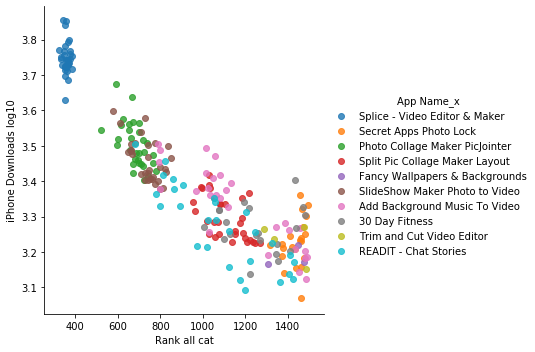

In [7]:
merged_data_all_cat['iPhone Downloads log10'] = np.log10(merged_data_all_cat['iPhone Downloads'])
g = sns.lmplot(data=merged_data_all_cat, y="iPhone Downloads log10", x="Rank all cat",hue ='App Name_x', fit_reg=False)
#g.set(ylim=(100, 7000), xlim=(0,2000))


Fitting the log data with a quadratic function

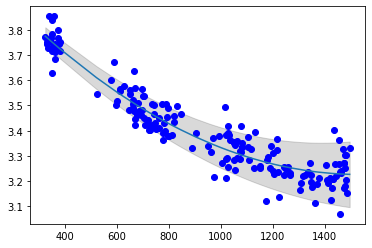

In [8]:
def exp_func(x, a, b, c):
    return a*x**2 + b*x + c

ydata = np.log10(merged_data_all_cat["iPhone Downloads"])
xdata = merged_data_all_cat["Rank all cat"]

#initial values
init_vals = [50, 1, 63] #initial guesses for the fit

#test-train split
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=45) 

#fitting the train test and plotting the results
coef, cov = curve_fit(exp_func, x_train, y_train, p0=init_vals, bounds=([-10, -10, -10], [15000, 1, 5000]))

#coefficients uncertainty
coef_unc = np.sqrt(np.diag(cov)) 

#converting the fit coefficients to ufloat type
coef_float = (ufloat(coef[0],coef_unc[0]), ufloat(coef[1],coef_unc[1]), ufloat(coef[2],coef_unc[2]))

#sorting values for plotting
x_train_sorted = x_train.sort_values(ascending=True) 

#predicting training set values
y_pred = exp_func(x_train_sorted, *coef_float)

#separating the nominal and std_dev values from the fit
y_pred_values  = unumpy.nominal_values(exp_func(x_train_sorted, *coef_float))
y_pred_std_devs = unumpy.std_devs(exp_func(x_train_sorted, *coef_float))

#plotting data with uncertainties
plt.plot(x_train, y_train, 'bo', label='data')
plt.plot(x_train_sorted, y_pred_values,"-")
bound_lower = y_pred_values - y_pred_std_devs  #conf intervals for the fitting curve
bound_upper = y_pred_values + y_pred_std_devs  #conf intervals for the fitting curve
plt.fill_between(x_train.sort_values(ascending=True), bound_lower, bound_upper, color = 'black', alpha = 0.15)

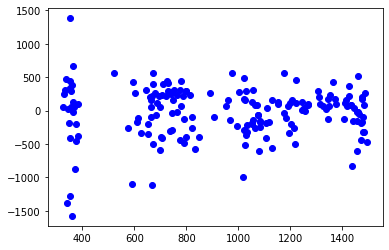

In [9]:
#predicting the nominal values for the train set
y_pred_train = unumpy.nominal_values(10**(exp_func(x_train, *coef_float)))

#plotting the residuals for the train set
plt.plot(x_train,(y_pred_train-10**y_train),"bo")

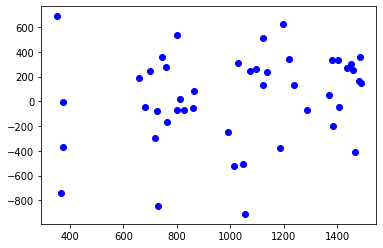

In [10]:
#predicting the nominal values for the test set
y_pred_test = unumpy.nominal_values(10**exp_func(x_test, *coef_float))

#plotting the residuals
plt.plot(x_test,(y_pred_test-10**y_test),"bo")

In [11]:
#RMSE
rmse_test = np.sqrt(((y_pred_test-10**y_test)**2).mean())
rmse_train = np.sqrt(((y_pred_train-10**y_train)**2).mean())
rmse_train, rmse_test, rmse_train/y_pred_train.mean(), rmse_test/y_pred_test.mean()

(383.1646849065359,
 364.5182974219882,
 0.13689307405657017,
 0.14667750646206937)

# Postmates

In [12]:
#predicting the total downloads for the Postmates app
postmates_predicted_downloads = 10**exp_func(data_postmates['postmates_iphone_rank_all_categories'], *coef_float)
print('Predicted Postmates downloads (CI): ', postmates_predicted_downloads.sum())

Predicted Postmates downloads (CI):  (1.95+/-0.15)e+05


# Over

I repeat the same analysis for the Over app, using the categorical rank instead than the overall one (which is not available for Over)

In [13]:
data_rank_bs_photo_video = pd.read_csv('ranks_BS_photo_video.csv',sep='\t',encoding = 'utf-16')
data_rank_bs_photo_video.columns = ['App ID', 'App Name', 'Country','Date', 'Rank Photo Video', 'Updated']
data_rank_bs_photo_video = data_rank_bs_photo_video.drop(data_rank_bs_photo_video.index[[0,1]])
data_rank_bs_photo_video = data_rank_bs_photo_video.drop(['Country', 'Updated'], axis = 1)
data_rank_bs_photo_video['App ID'] = data_rank_bs_photo_video['App ID'].astype(int)

In [14]:
merged_data_photo_video = pd.merge(data_bs, data_rank_bs_photo_video, how='inner', on=['Date', 'App ID'])
merged_data_photo_video = merged_data_photo_video.dropna(axis=0)
merged_data_photo_video = merged_data_photo_video.drop(['App Name_y'], axis = 1)
merged_data_photo_video['Rank Photo Video'] = merged_data_photo_video['Rank Photo Video'].astype(float)

In [15]:
merged_data_photo_video['iPhone Downloads log'] = np.log(merged_data_photo_video['iPhone Downloads'])

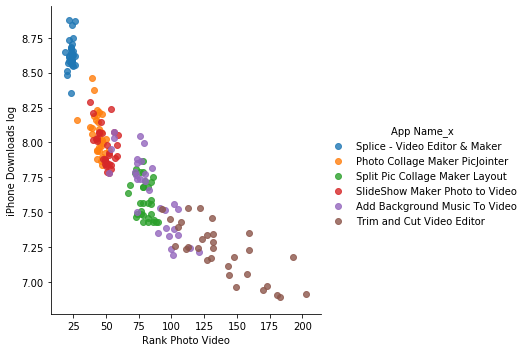

In [16]:
g = sns.lmplot(data=merged_data_photo_video, y="iPhone Downloads log", x="Rank Photo Video",hue ='App Name_x', fit_reg=False)
#g.set(ylim=(2000, 200))

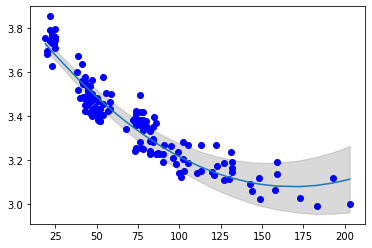

In [17]:
ydata = np.log10(merged_data_photo_video["iPhone Downloads"])
xdata = merged_data_photo_video["Rank Photo Video"]

init_vals = [1, 0, 63] #initial guesses for the fit

#test-train split
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=12) 

#fitting the train test and plotting the results (pv suffix stands for photo and video)
coef_pv, cov_pv = curve_fit(exp_func, x_train, y_train, p0=init_vals, bounds=([-100, -100, -100], [20000, 100, 20000]))

#coefficients uncertainty
coef_unc_pv = np.sqrt(np.diag(cov_pv)) 

#transforming coefficients to ufloat values
coef_float_pv = (ufloat(coef_pv[0],coef_unc_pv[0]), ufloat(coef_pv[1],coef_unc_pv[1]), ufloat(coef_pv[2],coef_unc_pv[2]))

#separating nominal values and std devs
x_train_sorted = x_train.sort_values(ascending=True)

y_pred_values  = unumpy.nominal_values(exp_func(x_train_sorted, *coef_float_pv))
y_pred_std_devs = unumpy.std_devs(exp_func(x_train_sorted, *coef_float_pv))



#Plotting the results (for some reason it works only the second time)
plt.plot(x_train, y_train, 'bo', label='data')
plt.plot(x_train_sorted, y_pred_values,"-")

bound_lower = y_pred_values - y_pred_std_devs  #conf intervals for the fitting curve
bound_upper = y_pred_values + y_pred_std_devs  #conf intervals for the fitting curve
#plotting the confidence intervals

plt.fill_between(x_train.sort_values(ascending=True), bound_lower, bound_upper, color = 'black', alpha = 0.15)


For some reason the plot works only the second time, don't know why..

The fitting function isn't realistic for ranks below 150 where it starts to increase. Maybe a 3 grade polynomial would work better?

In [18]:
#RMSE
y_pred_test = unumpy.nominal_values(10**exp_func(x_test, *coef_float_pv))
y_pred_train = unumpy.nominal_values(10**exp_func(x_train, *coef_float_pv))

rmse_test = np.sqrt(((y_pred_test-10**y_test)**2).mean())
rmse_train = np.sqrt(((y_pred_train-10**y_train)**2).mean())
rmse_train, rmse_test, rmse_train/y_pred_train.mean(), rmse_test/y_pred_test.mean()

(461.4162329222101, 694.4875109062177, 0.1712661480636586, 0.21221251239808736)

In [19]:
### predicting the total downloads for the Over app
x_data = data_over['over_iphone_rank_photo_video']
y_pred = 10**exp_func(x_data, *coef_float_pv)
print('Predicted Over dow\nloads: ', y_pred.sum())

Predicted Over dow
loads:  (3.8+/-0.9)e+04


# Investigating relationship between Photo and Video rank and the all category one

Creating a new data frame that contains both the categorical and the overall rank for the photo and video BS apps

In [20]:
rank_all_vs_photo_video = pd.merge(data_rank_bs, data_rank_bs_photo_video, how='inner', on=['Date', 'App ID'])
rank_all_vs_photo_video = rank_all_vs_photo_video.dropna(axis=0)
rank_all_vs_photo_video = rank_all_vs_photo_video.drop(['App Name_y'], axis = 1)
rank_all_vs_photo_video['Rank Photo Video'] = rank_all_vs_photo_video['Rank Photo Video'].astype(float)
rank_all_vs_photo_video['Rank all cat'] = rank_all_vs_photo_video['Rank all cat'].astype(float)

Plotting the data to look for a relationship

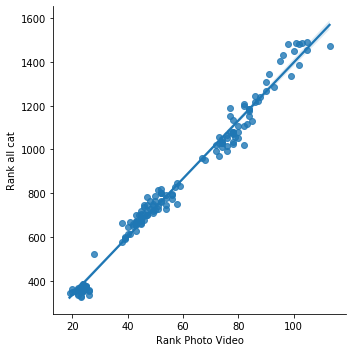

In [21]:
graph_all_vs_photo_video = sns.lmplot(data=rank_all_vs_photo_video, y="Rank all cat", x="Rank Photo Video")

Fitting with linear regression

Coefficients: 
 [[12.95832182]]    [91.27082395]


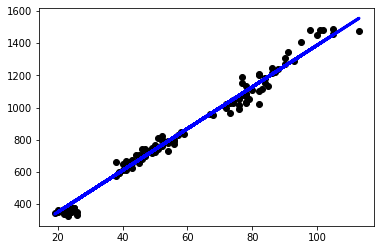

r square: 0.98


In [22]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression(fit_intercept = True)

x = rank_all_vs_photo_video['Rank Photo Video'].values.reshape(-1,1)
y = rank_all_vs_photo_video['Rank all cat'].values.reshape(-1,1)

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42) 
regr.fit(x_train,y_train)
y_pred = regr.predict(x_test)

# The coefficients
print('Coefficients: \n', regr.coef_, '  ', regr.intercept_)

slope, intercept = regr.coef_, regr.intercept_

# Plot output
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)

plt.show()
print('r square: %.2f'% r2_score(y_test, y_pred))

Create a new data frame which combines the categorical and overall rank data. When the overall rank is missing, it is replaced with the fitted value

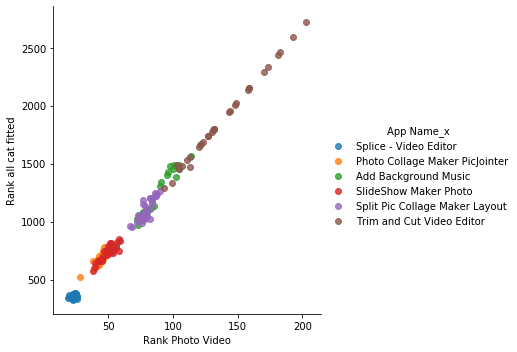

In [23]:
rank_all_vs_photo_video_fitted = pd.merge(data_rank_bs, data_rank_bs_photo_video, how='inner', on=['Date', 'App ID'])
rank_all_vs_photo_video_fitted = rank_all_vs_photo_video_fitted.drop(['App Name_y'], axis = 1) #dropping duplicate
rank_all_vs_photo_video_fitted['Rank Photo Video'] = rank_all_vs_photo_video_fitted['Rank Photo Video'].astype(float)
rank_all_vs_photo_video_fitted['Rank all cat'] = rank_all_vs_photo_video_fitted['Rank all cat'].astype(float)

#Filling missing overall rank values with fitted ones
rank_all_vs_photo_video_fitted['Rank all cat'].fillna((rank_all_vs_photo_video_fitted['Rank Photo Video']*slope[0][0]+intercept), inplace=True)
rank_all_vs_photo_video_fitted.columns = ['App ID', 'App Name_x', 'Date', 'Rank all cat fitted', 'Rank Photo Video']

#Plotting the result
graph_all_vs_photo_video = sns.lmplot(data=rank_all_vs_photo_video_fitted, y="Rank all cat fitted", x="Rank Photo Video",hue ='App Name_x', fit_reg=False)

Combining the rank and the downloads information in a new dataframe <br> This frame takes the overall rank when available, and the fitted overall rank for photo and video apps, when the overall one is not present

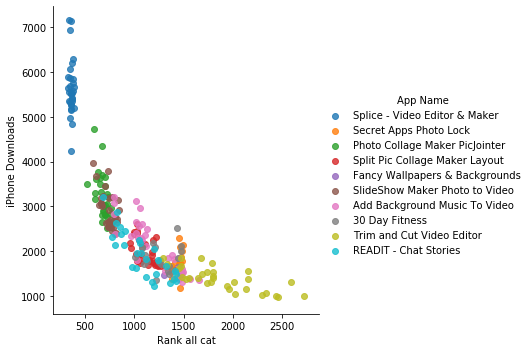

In [24]:
#Merging downloads and rank data for BS apps. The same done before, but this time we don't drop rows with missing values
merged_data_all_cat = pd.merge(data_bs, data_rank_bs, how='inner', on=['Date', 'App ID'])
merged_data_all_cat = merged_data_all_cat.drop(['App Name_y'], axis = 1)
merged_data_all_cat['Rank all cat'] = merged_data_all_cat['Rank all cat'].astype(float)

#Merging the fitted rank data, replacing missing values with fitted ones when possible (photo and video apps), dropping unwanted columns
merged_data_all_cat = pd.merge(merged_data_all_cat, rank_all_vs_photo_video_fitted, how='left', on=['Date', "App ID"])
merged_data_all_cat['Rank all cat'].fillna(merged_data_all_cat['Rank all cat fitted'], inplace=True)
merged_data_all_cat = merged_data_all_cat.drop(['App Name_x_y','Rank all cat fitted', 'Rank Photo Video'], axis = 1) 
merged_data_all_cat = merged_data_all_cat.dropna(axis=0)
merged_data_all_cat.columns = ['App ID', 'App Name','Date', 'iPad Downloads', 'iPhone Downloads', 'Rank all cat']

#Plotting the data
g = sns.lmplot(data=merged_data_all_cat, y="iPhone Downloads", x="Rank all cat",hue ='App Name', fit_reg=False)

Fitting the new data (same procedure as before)

(array([ 1.73431626e-07, -7.95246031e-04,  3.98053635e+00]),
 array([1.47392602e-08, 3.72991185e-05, 2.20201659e-02]))

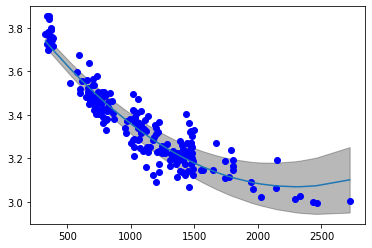

In [25]:
ydata = np.log10(merged_data_all_cat["iPhone Downloads"])
xdata = merged_data_all_cat["Rank all cat"]
#init_vals = [50, 0, 90, 90] #initial guesses for the fit
init_vals = [1, 1, 1] #initial guesses for the fit

#test-train split
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=42) 

#fitting the train test and plotting the results
#coef_fitted, cov_fitted = curve_fit(exp_func, x_train, y_train, p0=init_vals, bounds=([0, 0, 90, 0], [2000, 1, 2000, 2000]))
coef, cov = curve_fit(exp_func, x_train, y_train, p0=init_vals, bounds=([-10, -10, -10], [15, 10, 15]))

coef_unc = np.sqrt(np.diag(cov)) #coefficients uncertainty

coef_float = (ufloat(coef[0],coef_unc[0]), ufloat(coef[1],coef_unc[1]), ufloat(coef[2],coef_unc[2]))

x_train_sorted = x_train.sort_values(ascending=True) #sorting values for plotting

y_pred = exp_func(x_train_sorted, *coef_float)

y_pred_values  = unumpy.nominal_values(exp_func(x_train_sorted, *coef_float))
y_pred_std_devs = unumpy.std_devs(exp_func(x_train_sorted, *coef_float))

plt.plot(x_train, y_train, 'bo', label='data')
plt.plot(x_train_sorted, y_pred_values,"-")
bound_lower = y_pred_values - y_pred_std_devs  #conf intervals for the fitting curve
bound_upper = y_pred_values + y_pred_std_devs  #conf intervals for the fitting curve
plt.fill_between(x_train.sort_values(ascending=True), bound_lower, bound_upper, color = 'black', alpha = 0.15)
#coef, coef_unc




plt.fill_between(x_train_sorted, bound_lower, bound_upper, color = 'black', alpha = 0.15)

##predicting the total downloads for the Postmates app
#x_data = data_postmates['postmates_iphone_rank_all_categories']
#y_pred = 10**exp_func(x_data, *coef)

#print('Predicted Postmates downloads: ', y_pred.sum())
#coef, coef_unc_fitted

#1.80328347e-07, -8.07582168e-04,  3.98111643e+00]
coef, coef_unc

The fitting function isn't realistic for ranks below 1700 where it starts to increase, probably due to many more points at lower x value. Maybe a 3 grade polynomial would work better?

In [26]:
#predicting the total downloads for the Postmates app
x_data = data_postmates['postmates_iphone_rank_all_categories']
y_pred = 10**exp_func(x_data, *coef_float)
print('Predicted Postmates downloads: ', y_pred.sum())

Predicted Postmates downloads:  (1.78+/-0.10)e+05


In [27]:
#predicting the total downloads for the Over app
data_over['rank_iphone_all_fitted'] = data_over['over_iphone_rank_photo_video']*slope[0][0]+intercept
x_data = data_over['rank_iphone_all_fitted']
y_pred = 10**exp_func(x_data, *coef_float)
print('Predicted Over downloads: ', y_pred.sum())
#rank_all_vs_photo_video_fitted



Predicted Over downloads:  (3.7+/-0.9)e+04


# Finance Apps

I looked on SensorTower for other Finance Apps with both the categorical and overall rank information, trying to cover the whole 1-1500 range in the overall chart

https://sensortower.com/ios/US/venmo/app/venmo/351727428/category-rankings?search=&start_date=2017-10-01&end_date=2017-10-31&countries=US&category=0&chart_type=free&device=iphone&hourly=false&selected_tab=charts&date=2020-10-21&competitors=916741290&competitors=575923525&competitors=382107453&competitors=407558537&competitors=362348516&competitors=338010821&competitors=300238550&competitors=312325565&competitors=331763096&competitors=995112030&competitors=318142137&competitors=311548709&competitors=883324671&competitors=529615515&competitors=886427730&competitors=942571931&competitors=417970539

Combining the information for overall and categorical rank

In [28]:
rank_financeapps_all_cat = pd.read_csv('rank_finance_apps_all_categories.csv',encoding = 'utf-16')
rank_financeapps_all_cat.columns = ['App ID', 'App Name', 'Country','Date', 'Rank all cat', 'Updated']
rank_financeapps_all_cat = rank_financeapps_all_cat.drop(rank_financeapps_all_cat.index[[0,1]])
rank_financeapps_all_cat = rank_financeapps_all_cat.drop(['Country', 'Updated'], axis = 1)
rank_financeapps_all_cat = rank_financeapps_all_cat.dropna(axis=0)


rank_financeapps_finance = pd.read_csv('ranks_finance_apps_finance.csv',encoding = 'utf-16')
rank_financeapps_finance.columns = ['App ID', 'App Name', 'Country','Date', 'Rank finance', 'Updated']
rank_financeapps_finance = rank_financeapps_finance.drop(rank_financeapps_finance.index[[0,1]])
rank_financeapps_finance = rank_financeapps_finance.drop(['Country', 'Updated'], axis = 1)
rank_financeapps_finance = rank_financeapps_finance.dropna(axis=0)

merged_data_finance_apps = pd.merge(rank_financeapps_all_cat, rank_financeapps_finance, how='inner', on=['Date', 'App ID'])

merged_data_finance_apps = merged_data_finance_apps.drop(['App Name_y'], axis = 1)
merged_data_finance_apps['Rank finance'] = merged_data_finance_apps['Rank finance'].astype(float)
merged_data_finance_apps['Rank all cat'] = merged_data_finance_apps['Rank all cat'].astype(float)

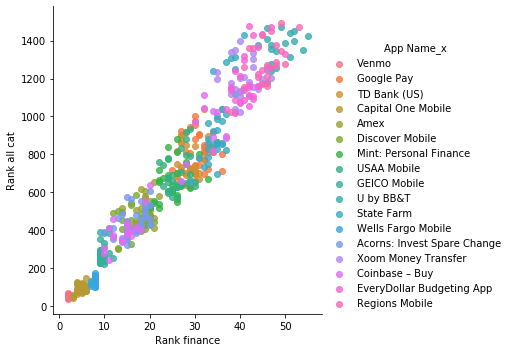

In [29]:
#Plotting the data
g = sns.lmplot(data=merged_data_finance_apps, y="Rank all cat", x="Rank finance",hue ='App Name_x', fit_reg=False)

Coefficients: 
 [[28.7218376]]    [-35.20407833]


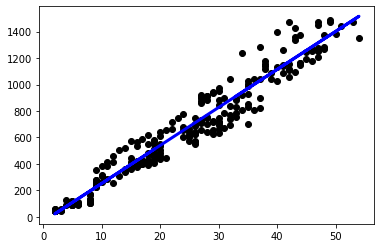

r square: 0.95


In [30]:
# Fitting with a linear regression
regr = linear_model.LinearRegression(fit_intercept = True) 

x = merged_data_finance_apps['Rank finance'].values.reshape(-1,1)
y = merged_data_finance_apps['Rank all cat'].values.reshape(-1,1)

#Test-train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42) 

regr.fit(x_train,y_train)
y_pred = regr.predict(x_test)

# The coefficients
print('Coefficients: \n', regr.coef_, '  ', regr.intercept_)

slope_finance = regr.coef_[0][0].astype(float)
intercept_finance = regr.intercept_

# Plot outputs
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)

plt.show()
print('r square: %.2f'% r2_score(y_test, y_pred))

Adding a new column to the dataframe with the overall rank

In [31]:
data_spendingtracker['iphone rank all cat'] = data_spendingtracker['spendingtracker_iphone_rank_finance']*slope_finance + intercept_finance 


In [32]:
#predicting the total downloads for the Spending Tracker app

x_data = data_spendingtracker['iphone rank all cat']
y_pred = 10**exp_func(x_data, *coef_float)
print('Predicted Over downloads: ', y_pred.sum())
#rank_all_vs_photo_video_fitted



Predicted Over downloads:  (3.8+/-0.9)e+04


### Try to fit data day by day 

There might be fluctuations in the relationship between rank and donwloads that are missed in the "all data" fit done before. On the other hand, we are fitting way less data, which results in a worse accuracy. The idea behind the fitting is the same as before

Posmates predicted downloads (CI):  137897.35047758438 187339.0252312037 236780.69998482318


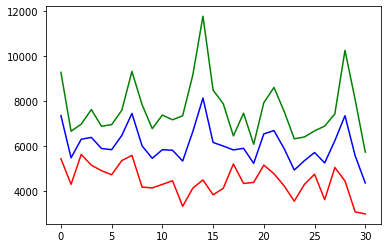

In [33]:
predictions = []
lower_predictions = []
upper_predictions = []
dates = []
residuals = []
merged_data_all_cat = merged_data_all_cat.sort_values(by=['Date'])


for date in data_postmates['Date']:
    #date = '2017-10-25'
    app_name = merged_data_all_cat['App Name'].where(merged_data_all_cat['Date']==date).dropna().sort_index()
    iphone_downloads = np.log10(merged_data_all_cat['iPhone Downloads'].where(merged_data_all_cat['Date']==date).dropna().sort_index())    
    rank_all_cat = merged_data_all_cat['Rank all cat'].where(merged_data_all_cat['Date']==date).dropna().sort_index()
    coef, cov = curve_fit(exp_func, rank_all_cat, iphone_downloads, p0=init_vals, bounds=([-10, -10, -10], [20000, 1, 2000]))
    coef_unc = np.sqrt(np.diag(cov))
    y_pred_fit = 10**exp_func(rank_all_cat, *coef)
    residuals = np.append(residuals,y_pred_fit - 10**iphone_downloads)
    #print(residuals)
    coef_float = (ufloat(coef[0],coef_unc[0]), ufloat(coef[1],coef_unc[1]), ufloat(coef[2],coef_unc[2]))
    #residuals.append(y_pred_fit - 10**iphone_downloads)
    x = data_postmates['postmates_iphone_rank_all_categories'].where(data_postmates['Date']==date).dropna()
    y_pred_values  = unumpy.nominal_values(10**exp_func(x, *coef_float))
    y_pred_std_devs = unumpy.std_devs(10**exp_func(x, *coef_float))
    lower_pred = y_pred_values - y_pred_std_devs
    upper_pred = y_pred_values + y_pred_std_devs
    predictions = np.append(predictions,y_pred_values)
    lower_predictions = np.append(lower_predictions,lower_pred)
    upper_predictions = np.append(upper_predictions,upper_pred)
    #plt.clf()
    #plt.scatter(rank_all_cat, 10**iphone_downloads,  color='black')
    #plt.plot(rank_all_cat.sort_values(ascending=True), 10**exp_func(rank_all_cat.sort_values(ascending=True), *coef), color='blue', linewidth=3)

print("Posmates predicted downloads (CI): ",lower_predictions.sum(), predictions.sum(), upper_predictions.sum())

plt.plot(lower_predictions,"r-")
plt.plot(upper_predictions,"g-")
plt.plot(predictions,"b-")


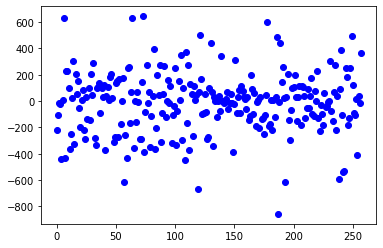

In [34]:
plt.plot(residuals,"bo")

The residuals are smaller (each point has a larger weight in its individual fit now) but the interval of the predictions is larger. This is expected since each fit is far less precise than before, being it obtained from fewer points